<a id='sec_Notebooks_algoritmos_oraculo'></a> 
# Algoritmos del Oráculo

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\cal H}} $
$ \newcommand{\cg}[1]{{\rm C}#1} $

## Índice

- **[1 - El problema de Bernstein-Vazirani](#sec_Notebooks_algoritmos_oraculo_1)**
    - **[1.1 - Problema](#sec_Notebooks_algoritmos_oraculo_1.1)**
    - **[1.2 - Implementación](#sec_Notebooks_algoritmos_oraculo_1.2)**
- **[2 - El problema de Simon](#sec_Notebooks_algoritmos_oraculo_2)**
    - **[2.1 - Problema](#sec_Notebooks_algoritmos_oraculo_2.1)**
    - **[2.2 - Implementación](#sec_Notebooks_algoritmos_oraculo_2.2)**

In [1]:
# No olvidar que en "Google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime ipywidgets
except ImportError:
    print("NOT in colab")

NOT in colab


In [2]:
# Importamos las librerías y clases necesarias
import numpy as np
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector

# Import para visualización
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex

In [3]:
# Importamos el simulador. Con "method" le especificamos el método de simulación
simulador = AerSimulator(method = 'statevector')

<a id='sec_Notebooks_algoritmos_oraculo_1'></a>
## El problema de Bernstein-Vazirani

<a id='sec_Notebooks_algoritmos_oraculo_1.1'></a>
### Problema

-  **Promesa**: $f$ es una *función lineal*, definida por una cadena de bits $a \in \{0,1\}^n$
<br>
$$f(x) = a\cdot x  = a_{n-1} x_{n-1} \oplus ....\oplus a_0 x_0$$
<br>

- **Problema**: hallar $a = a_{n-1} \ldots a_0$ 

- **Solución**: correr el circuito una vez y medir el estado final

\begin{eqnarray}
\ket{\Phi} &=& \frac{1}{2^n} \sum_{x,y=0}^{2^n-1}(-1)^{f(x)+ y \cdot x}\ket{y}
=  
\frac{1}{2^n}\sum_{y=0}^{2^n-1} \left(\sum_{x=0}^{2^n-1}(-1)^{(a+y)\cdot x}\right)\ket{y} ~\nonumber\\  \rule{0mm}{10mm}
&=&  
\frac{1}{2^n}\sum_{y=0}^{2^n-1} \left(\sum_{x=0}^{2^n-1}(-1)^{(-a+y)\cdot x}\right)\ket{y}\nonumber\\ \rule{0mm}{10mm}
 &=&  \frac{1}{2^n} \sum_{y=0}^{2^n-1} 2^n \delta_{(-a+y),0} \ket{y} \nonumber\\ \rule{0mm}{10mm}
&=& \rule{0mm}{5mm} \ket{a_0a_1\cdots a_{n-1}} \nonumber 
\end{eqnarray}

¡ Una **única**  medida del estado final da $a$ !

<a id='sec_Notebooks_algoritmos_oraculo_1.2'></a>
### Implementación

En primer lugar generamos un oráculo lineal $f(x)=x\cdot a$ con una cadena $a=(a_{n-1},\ldots a_0)$ oculta de longitud $n$

In [8]:
def random_linear_oracle(n):  #n es la longitud de la cadena a oculta

    import random, string
    a = ''.join(random.choices(['0','1'], k=n))
    print('cadena oculta=',a)  
    qc = QuantumCircuit(n+1) # el ultimo registro es la salida |f(x)> = |a.x>

    
    for i, ai in enumerate(reversed(a)):  # ponemos reversed para usar el convenio de qiskit
        if ai == '1':
            qc.cx(i,n)    
    return qc

random_linear_oracle(4).draw()

cadena oculta= 1100


q_0: ──────────
               
q_1: ──────────
               
q_2: ──■───────
       │       
q_3: ──┼────■──
     ┌─┴─┐┌─┴─┐
q_4: ┤ X ├┤ X ├
     └───┘└───┘

Ahora implementamos el oráculo en el algoritmo de BV

In [9]:
def BV_circuit(linear_oracle,n):
    #n: número de bits
    #a: coeficiente oculto
    #return: circuito

    qreg = QuantumRegister(n+1)
    creg = ClassicalRegister(n)
    qc = QuantumCircuit(qreg,creg)

    #Hacemos máxima superposición
    qc.h(qreg)

    #Ponemos el último qubit en el estado |->
    qc.z(qreg[-1])

    qc.barrier()
    
    # añadimos el oráculo lineal con la cadena oculta
    qc.append(linear_oracle.to_gate(),qreg[:])
    
    qc.barrier()
    

    #Aplicamos Hadamard de nuevo

    qc.h(qreg[0:-1])

    qc.measure(qreg[0:-1],creg)

    return qc

Vamos a correr un ejemplo concreto 

cadena oculta= 0101


/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


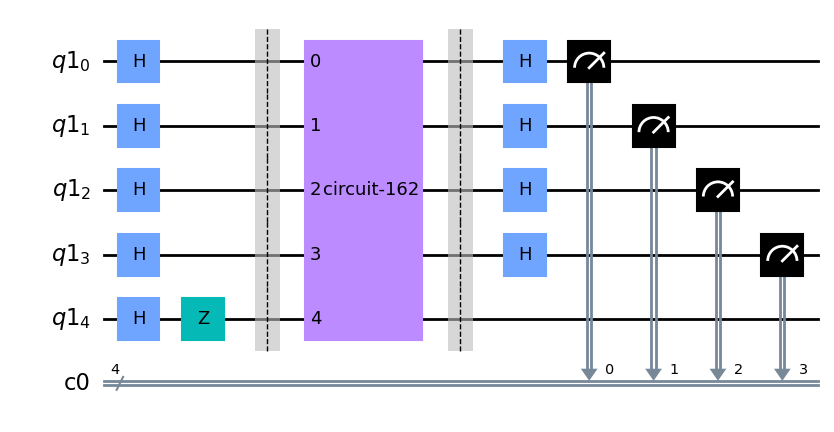

In [10]:
n = 4
linear_oracle = random_linear_oracle(n)

circuito = BV_circuit(linear_oracle,n)

circuito.draw(output = 'mpl')

Ahora podemos extraer la cadena $a$ en *una sóla invocación* del oráculo

In [11]:
# transpilamos
t_circuit = transpile(circuito, backend = simulador)

In [12]:
# Ejecutamos la simulación con 1000 shots 
result = simulador.run(t_circuit, shots = 1000).result()
counts = result.get_counts()
counts

{'0101': 1000}

<a id='sec_Notebooks_algoritmos_oraculo_2'></a>
## El problema de Simon   

<a id='sec_Notebooks_algoritmos_oraculo_2.1'></a>
### Problema

- **Promesa:** Consideremos ahora una función $f:\{0,1\}^n \to \{0,1\}^n$ con la siguiente propiedad: la función $f$ puede ser de dos tipos:
    - **Uno-a-uno**: asigna una salida única para cada entrada. Un ejemplo sería el siguiente:
        <br>
        $$	
        f(00) \rightarrow 01 ~~~~
        f(01) \rightarrow 11 ~~~~
        f(10) \rightarrow 00 ~~~~
        f(11) \rightarrow 10 
        $$

    - **Dos-a-uno**: asigna exactamente dos entradas a cada salida única. Este mapeo dos-a-dos es de acuerdo con una cadena de bits oculta $a$, donde
	
        $$
		\text{dados } x_1, x_2 \text{ tal que } f(x_1) = f(x_2), \text{ es seguro que } x_1 \oplus x_2 = a
		$$
		
        Equivalentemente, podemos escribir: 
		
        $$ 
		f(x_1 \oplus a ) = f(x_2).
		$$
		
        Un ejemplo con una función que toma 4 entradas es
		<br>
        $$
		f(00) \rightarrow 01 ~~~~
		f(01) \rightarrow 11 ~~~~
		f(10) \rightarrow 01 ~~~~
		f(11) \rightarrow 11 
		$$
		
        Donde $00 \oplus 10 =  10$ y $01 \oplus 11 = 10$, con lo cual $s =10$

 - **Problema:** Dada esta caja negra $f$, como de rápido podemos determinar si $f$ es uno-a-uno o dos-a-uno? Entonces, si $f$ resulta ser dos-a-uno, como de rápido podemos determinar $a$? En realidad los dos casos consisten en encontrar $a$, pues el caso uno-a-uno corresponde con $a=00\dots$. (Clásicamente, si queremos conocer $s$ con 100\% de certeza, tenemos que verificar hasta $2(n-1) +1$ entradas, donde $n$ es el número de bits de la entrada. Es decir, necesitamos verificar la mitad de casos.)
		
 - **Solución:** El circuito será el de la Fig:
	

<figure><center>
<img src="./Figuras/Fig_algoritmos_SimonCircuit.png" align=center alt="" width='500px'/>
</center></figure>

<a id='sec_Notebooks_algoritmos_oraculo_2.2'></a>
### Implementación

In [13]:
def binary_function(f_outputs): 
 
    from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
    from qiskit.circuit.library import MCXGate

    #claramente el número de n-bits de entrada tiene que ser tal que 2^n acomode el número de salidas de f
    n = int(np.ceil(np.log2(len(f_outputs))))
    
    #sin embargo los outputs pueden tener longitud arbitraria
    m = len(f_outputs[0])
    
    #generamos todos los posibles inputs en binario, completando con ceros hasta tener strings de n bits
    inputs = [format(i, 'b').zfill(n) for i in range(2**n)]
    # verificamos que hay tantos outputs como posibles inputs 
    # assert len(inputs) == len(f_outputs)

    qr_input = QuantumRegister(n)
    qr_output = QuantumRegister(m)
    qc = QuantumCircuit(qr_input, qr_output)


    # Hacemos un bucle sobre los inputs
    for i,input_str in enumerate(inputs[:len(f_outputs)]):
        ctrl_state= int(input_str[::],2)

        # Para cada input, i, hacemos un bucle sobre cada  cúbit del output     
        for j,output_bit in enumerate(f_outputs[i]):
            if output_bit =='1':
                qc.append(MCXGate(len(input_str), ctrl_state=ctrl_state),qr_input[:]+[qr_output[n-j-1]])


    return qc

In [14]:
# promesa: esta función contiene un periodo binario
f_outputs = ['1111', '1011', '0011', '1000', '0101', '0100', 
               '0000', '1110', '0101', '0100', '0000', '1110', 
               '1111', '1011', '0011', '1000']

# creamos el oráculo y lo transformamos en una puerta 
simon_oracle_gate = binary_function(f_outputs).to_gate()

# verificamos que se trata de una función de n en n bits
n_input = int(np.log2(len(f_outputs))) #número de outputs
m_output =len(f_outputs[0])            #longitud de cada output
assert(n_input == m_output)

<div class="alert alert-block alert-success">
<p style="color: DarkGreen;">
<b>Ejercicio</b>:
<br>        
Completa la  construcción del algoritmo de Simon 
<br> 
</p>
<details><summary> >> <i>Solución</i> </summary>

    
    # Aplica la puerta de Walsh-Hadamard al primer registro
    qc.h(qr_in)
    qc.barrier()
    
    # Aplicamos el oráculo
    qc.append(simon_oracle_gate,qr_in[:]+qr_out[:])    
    qc.barrier()
    
    # Medimos el registro de los cúbits de |f(x)>
    qc.measure(qr_out, cr)
    qc.barrier()


    # Volvemos a aplicar la puerta de Walsh-Hadamard al primer registro
    qc.h(qr_in)
    qc.barrier()
    
    # Finalmente medimos el registro de los inputs |x>

    qc.measure(qr_in, cr)
    
</details>
</div>

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


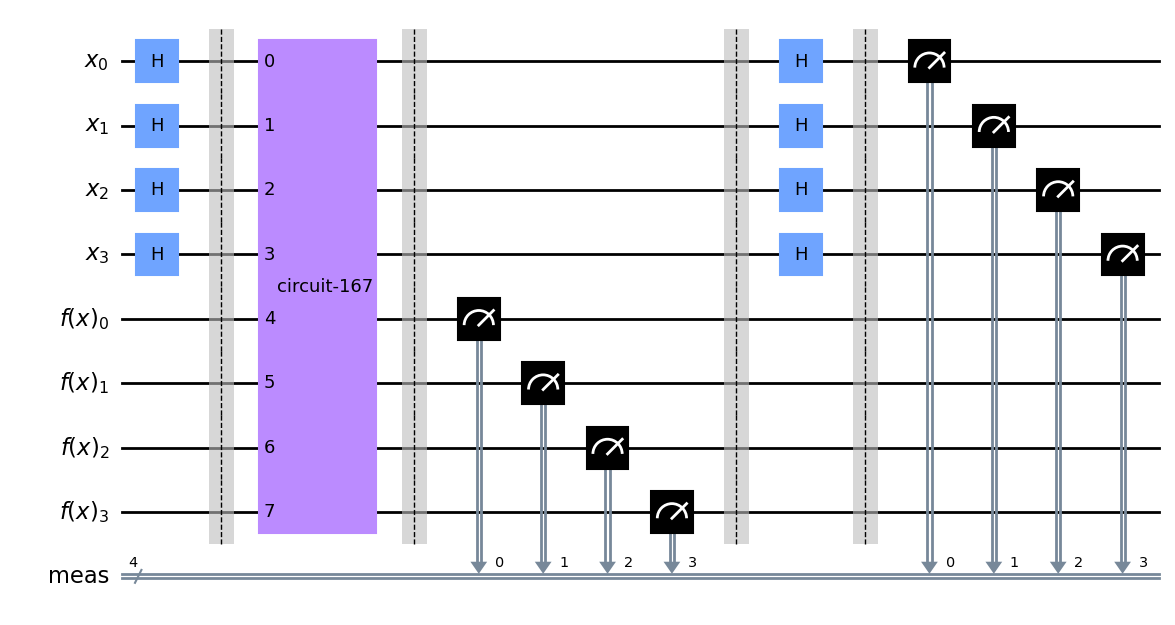

In [15]:
n=n_input

qr_in = QuantumRegister(n, name='x')
qr_out = QuantumRegister(n, name='f(x)')
cr = ClassicalRegister(n, name='meas')
    
# Construimos el circuito
qc = QuantumCircuit(qr_in, qr_out, cr, name='q')
    
#========Escribe tu código aquí========


#======================================
    
qc.draw('mpl')

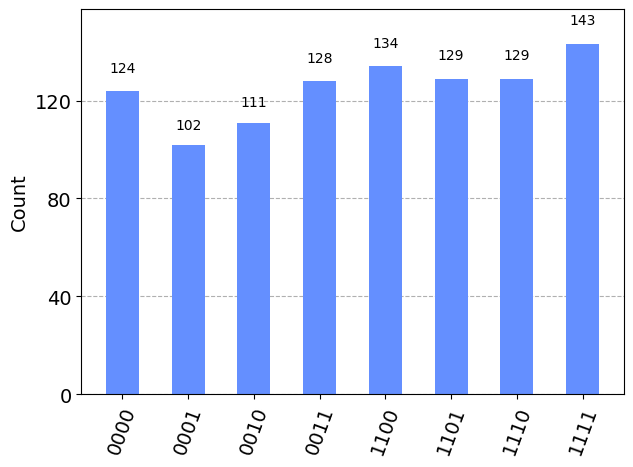

In [16]:
from qiskit import Aer, execute

shots_exe = 1000

backend = Aer.get_backend('qasm_simulator')
job     = execute(qc, backend, shots = shots_exe)
result  = job.result()
counts  = result.get_counts()

from qiskit.tools.visualization import plot_histogram

plot_histogram(counts)

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table